# Import Packages

In [123]:
# built-in
from collections import Counter
import itertools
import os.path
import re

# third-party (pip install required)
import matplotlib
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pylab
from pymodulon.compare import compare_ica
from pymodulon.io import load_json_model
import seaborn as sns

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [3]:
K12_PATH = '../../data/k12_modulome//'
FIG_PATH = 'summarize_imodulons_figs'
ANNOTATION_PATH = '../../data/annotation/'

In [4]:
ica_data = load_json_model(os.path.join(K12_PATH, 'k12_modulome.json.gz'))
imod_table = ica_data.imodulon_table

# Category Breakdowns

## bar_and_pie Function

In [12]:
def bar_and_pie(category, figsize=(6, 2.5), cmap='tab10', im_table=imod_table):
    imod_cat_counts = Counter(im_table[category])
    sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
    color_dict = dict(zip(sorted_cats, [pylab.get_cmap(cmap)(i/(len(sorted_cats))) for i in range(0,len(sorted_cats))]))
    color_dict['Unexplained'] = 'gray'
    
    fig, (ax_bar, ax_pie_var) = plt.subplots(1, 2, figsize=figsize)

    bar_range = -1 * np.arange(0, len(sorted_cats))
    ax_bar.barh(bar_range, sorted_counts, tick_label=sorted_cats, color=[color_dict[cat] for cat in sorted_cats])
    ax_bar.set_xlabel('# of iModulons', fontsize=10)
    ax_bar.tick_params(axis='both', labelsize=10)
    if len(sorted_counts) < 20:
        for height, count in zip(bar_range, sorted_counts):
            ax_bar.text(count+1, height, count, fontsize=10, va='center')
        ax_bar.set_xlim(right=sorted_counts[0] + 15)
    for i in ax_bar.spines.values():
        i.set_linewidth(0.6)
    ax_bar.grid(visible=True, axis='x', linewidth=0.5)
    
    exp_vars = []
    exp_var_tot = im_table['exp_var'].sum()
    # manually add in the "unexplained" category
    for cat in sorted_cats:
        exp_var = im_table[im_table[category] == cat]['exp_var'].sum()
        exp_vars.append(exp_var)
    sorted_vars, sorted_cats_var = zip(*sorted(zip(exp_vars, sorted_cats), key=lambda tup: tup[0], reverse=True))

    # make unexplained last
    unexp_var = 1 - im_table['exp_var'].sum()
    sorted_vars = list(sorted_vars)
    sorted_vars.append(unexp_var)
    sorted_cats_var = list(sorted_cats_var)
    sorted_cats_var.append('Unexplained')

    
    pie_labels_var = []
    for cat, var in zip(sorted_cats_var, sorted_vars):
        if var < 0.045 and len(sorted_cats_var) > 4:
            pie_labels_var.append('')
        else:
            pie_labels_var.append(f'{max(int(np.round(var*100, decimals=0)), 1)}%')

    ax_pie_var.pie(sorted_vars, labels=pie_labels_var, colors=[color_dict[cat] for cat in sorted_cats_var],
              labeldistance=1.1, textprops={'fontsize': 9, 'ha': 'center'}, wedgeprops={'edgecolor': 'k', 'linewidth': 0.5})
    ax_pie_var.set_title('Total Variance', fontsize=11)
    
    plt.tight_layout()
    
    return fig

## Enrichment Category

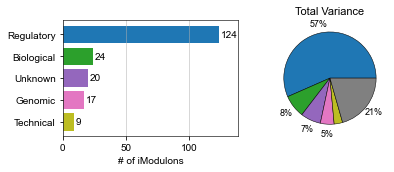

In [9]:
fig_enrich = bar_and_pie('enrichment_category', cmap='tab10', figsize=(6, 2.5))
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_enrichment.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_enrichment.png'), bbox_inches='tight', dpi=400)

## System Category

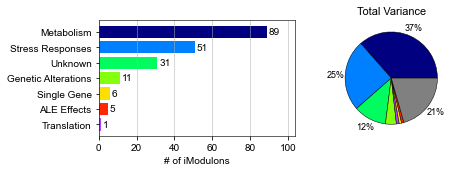

In [10]:
fig_system = bar_and_pie('system_category', figsize=(7, 2.5), cmap='gist_ncar')
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_system.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_system.png'), bbox_inches='tight', dpi=400)

## Functional Category

In [13]:
# combine some low-exp-var categories so there aren't too many colors in this plot
func_cat_to_var = {}
for func_cat, func_cat_df in imod_table.groupby('functional_category'):
    func_cat_to_var[func_cat] = func_cat_df['exp_var'].sum()
sorted_cat_to_var = sorted(list(func_cat_to_var.items()), key=lambda tup: tup[1], reverse=True)

n_max = 12
other_cats = [tup[0] for tup in sorted_cat_to_var[n_max:]]
func_im_table = imod_table.copy()
func_im_table = func_im_table.assign(functional_category=func_im_table['functional_category'].apply(lambda cat: 'Other' if cat in other_cats else cat))

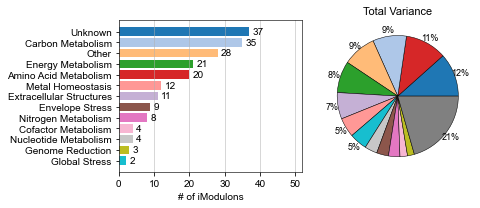

In [14]:
fig_system = bar_and_pie('functional_category', figsize=(7, 3), cmap='tab20', im_table=func_im_table)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_function.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_function.png'), bbox_inches='tight', dpi=400)

# High Variance iMs

/var/folders/q2/bdjskmzs1n9fbb14bmvhdz500000gn/T/ipykernel_61026/639581159.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')


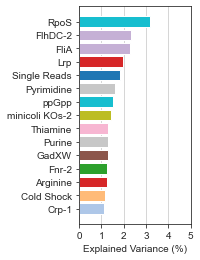

In [15]:
sns.set_style('ticks')
sorted_imod_table = func_im_table.sort_values(by='exp_var', ascending=False)
imod_cat_counts = Counter(func_im_table['functional_category'])
sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
color_dict = dict(zip(sorted_cats, [pylab.get_cmap('tab20')(1.*i/(len(sorted_cats))) for i in range(0,len(sorted_cats))]))

_, ax = plt.subplots(figsize=(2, 4))
n_top = 15
for i, im_row in enumerate(sorted_imod_table.itertuples()):

    if i < n_top:
        ax.barh(0-i, im_row.exp_var*100, color=color_dict[im_row.functional_category])
        
ax.set_xlabel('Explained Variance (%)')
ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')
ax.set_yticks(range(-n_top+1, 1))
ax.set_xticks(range(6))
ax.xaxis.grid(True)
for i in ax.spines.values():
    i.set_linewidth(0.8)
plt.savefig(os.path.join(FIG_PATH, 'high_variance_iMs.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'high_variance_iMs.png'), bbox_inches='tight', dpi=400)

# RegulonDB Coverage

In [5]:
trn = pd.read_csv(os.path.join(ANNOTATION_PATH, 'TRN.csv'))

all_p1k_regs = []
all_p1k_reg_interacts = []
for _, imod_row in imod_table.iterrows():
    im_regs = imod_row['regulator']
    if pd.notna(im_regs):
        regs = re.split(f'/|\+', im_regs)
        all_p1k_regs.extend(regs)
        im_genes = ica_data.view_imodulon(imod_row.name).index
        all_p1k_reg_interacts.extend(list(itertools.product(regs, im_genes)))

all_p1k_regs = list(set(all_p1k_regs))
all_p1k_reg_interacts = list(set(all_p1k_reg_interacts))

# now annotate the trn with the info from imodulon table
trn = trn.assign(
    reg_in_ims=trn['regulator'].apply(lambda reg: reg in all_p1k_regs),
    interact_in_ims=trn.apply(lambda row: (row['regulator'], row['gene_id']) in all_p1k_reg_interacts, axis=1)
)

trn = trn[trn['regulator'] != 'RpoD']

by_reg = trn.groupby('regulator').sum()
by_reg = by_reg.assign(
    evidence=by_reg.evidence.apply(lambda ev: 'Weak' if ev == 0 else 'Strong'),
    reg_in_ims=by_reg.reg_in_ims.apply(lambda in_im: in_im != 0),
    n_interact=trn.groupby('regulator').count().get('gene_name')
)

In [6]:
n_strong_in_im = by_reg[(by_reg['evidence'] == 'Strong') & (by_reg['reg_in_ims'])].shape[0]
n_strong_total = by_reg[(by_reg['evidence'] == 'Strong')].shape[0]

print(f'{n_strong_in_im}/{n_strong_total} ({n_strong_in_im/n_strong_total*100:.0f}%) regulators with some strong evidence in iModulons')

all_in_im = by_reg[by_reg['reg_in_ims']].shape[0]
all_total = by_reg.shape[0]
print(f'{all_in_im}/{all_total} ({all_in_im/all_total*100:.0f}%) regulators in iModulons')

n_strong_interact_in_im = trn[(trn['evidence'] > 0) & (trn['interact_in_ims'])].shape[0]
n_strong_interact_w_reg_in_im = trn[(trn['evidence'] > 0) & (trn['reg_in_ims'])].shape[0]
n_strong_interact = trn[(trn['evidence'] > 0)].shape[0]

print(f'{n_strong_interact_in_im}/{n_strong_interact} ({n_strong_interact_in_im/n_strong_interact*100:.0f}%) strong evidence interactions in iModulons',
      f'({n_strong_interact_w_reg_in_im} [{n_strong_interact_w_reg_in_im/n_strong_interact*100:.0f}%] strong interactions have regulator in iModulon)')

all_interact_in_im = trn[trn['interact_in_ims']].shape[0]
n_interact_w_reg_in_im = trn[trn['reg_in_ims']].shape[0]
all_interact_total = trn.shape[0]

print(f'{all_interact_in_im}/{all_interact_total} ({all_interact_in_im/all_interact_total*100:.0f}%) interactions in iModulons',
      f'({n_interact_w_reg_in_im} [{n_interact_w_reg_in_im/all_interact_total*100:.0f}%] interactions have regulator in iModulon)')

100/190 (53%) regulators with some strong evidence in iModulons
130/370 (35%) regulators in iModulons
1214/3417 (36%) strong evidence interactions in iModulons (3000 [88%] strong interactions have regulator in iModulon)
2297/9092 (25%) interactions in iModulons (7256 [80%] interactions have regulator in iModulon)


## Number of Regulators/Interactions

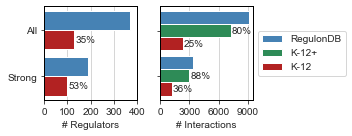

In [8]:
sns.set_style('ticks')
fig, (ax_tfs, ax_ris) = plt.subplots(1, 2, figsize=(5, 2))

ax_tfs.barh(0.125, n_strong_in_im, height=0.25, color='firebrick')
ax_tfs.barh(0.375, n_strong_total, height=0.25, color='steelblue')
ax_tfs.text(n_strong_in_im + 5, 0.125, f'{n_strong_in_im/n_strong_total*100:.0f}%', va='center')
ax_tfs.barh(0.725, all_in_im, height=0.25, color='firebrick')
ax_tfs.barh(0.975, all_total, height=0.25, color='steelblue')
ax_tfs.text(all_in_im + 5, 0.725, f'{all_in_im/all_total*100:.0f}%', va='center')
for s in ax_tfs.spines.values():
    s.set_linewidth(1)
    s.set_color('black')
ax_tfs.set_xlabel('# Regulators')
ax_tfs.set_yticks([0.25, 0.85])
ax_tfs.set_yticklabels(['Strong', 'All'])
ax_tfs.set_xticks(np.arange(0, 500, 100))
ax_tfs.xaxis.grid(True)

ax_ris.barh(0.625, n_strong_interact, height=0.25, color='steelblue', label='RegulonDB')
ax_ris.barh(0.375, n_strong_interact_w_reg_in_im, height=0.25, color='seagreen', label='K-12+')
ax_ris.barh(0.125, n_strong_interact_in_im, height=0.25, color='firebrick', label='K-12')
ax_ris.text(n_strong_interact_in_im + 100, 0.125, f'{n_strong_interact_in_im/n_strong_interact*100:.0f}%', va='center')
ax_ris.text(n_strong_interact_w_reg_in_im + 100, 0.375, f'{n_strong_interact_w_reg_in_im/n_strong_interact*100:.0f}%', va='center')
ax_ris.barh(0.975, all_interact_in_im, height=0.25, color='firebrick')
ax_ris.barh(1.225, n_interact_w_reg_in_im, height=0.25, color='seagreen')
ax_ris.barh(1.475, all_interact_total, height=0.25, color='steelblue')
ax_ris.text(all_interact_in_im + 100, 0.975, f'{all_interact_in_im/all_interact_total*100:.0f}%', va='center')
ax_ris.text(n_interact_w_reg_in_im + 100, 1.225, f'{n_interact_w_reg_in_im/all_interact_total*100:.0f}%', va='center')
for s in ax_ris.spines.values():
    s.set_linewidth(1)
    s.set_color('black')
ax_ris.set_xlabel('# Interactions')
ax_ris.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax_ris.set_yticks([0.375, 1.225])
ax_ris.set_yticklabels([])
ax_ris.set_xticks(np.arange(0, 12000, 3000))
ax_ris.xaxis.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'regulatory_coverage_bars.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'regulatory_coverage_bars.png'), dpi=400, bbox_inches='tight')

## Distribution of Regulon Sizes Covered

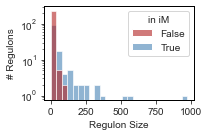

In [19]:
by_reg_fixed = by_reg.rename(columns={'reg_in_ims': 'in iM'})

_, ax = plt.subplots(figsize=(3, 2))

sns.histplot(x='n_interact', hue='in iM', palette=['firebrick','steelblue'], data=by_reg_fixed, bins=25, alpha=0.6,ax=ax)
ax.set_yscale('log')
ax.set_ylabel('# Regulons')
ax.set_xlabel('Regulon Size')
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'covered_regulon_sizes.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'covered_regulon_sizes.png'), dpi=400, bbox_inches='tight')

# PRECISE -> PRECISE 1K -> K12 Modulome

## Load PRECISE and PRECISE-1K

In [9]:
PRECISE_PATH = '../../data/precise/'
P1K_PATH = '../../data/precise1k/'

In [10]:
precise = load_json_model(os.path.join(PRECISE_PATH, 'precise.json.gz'))
p1k = load_json_model(os.path.join(P1K_PATH, 'precise1k.json.gz'))

## Compare iMs from Datasets

In [179]:
precise_p1k_links = compare_ica(precise.M, p1k.M, plot=False, method='spearman')
p1k_k12_links = compare_ica(p1k.M, ica_data.M, plot=False)
all_links = [(tup[0], tup[1], 'P1.0', tup[2]) for tup in precise_p1k_links] + [(tup[0], tup[1], 'K-12', tup[2]) for tup in p1k_k12_links]

In [182]:
links_to_remove = [
    ('UC-1', 'UC-K12-3', 'K-12'),
    ('UC-3', 'Fatty Acid', 'K-12'),
    ('Thr/Ser-1', 'Lysine', 'K-12'),
    ('FDH-O', 'UC-K12-8', 'K-12'),
    ('UC-9', 'Exuronate', 'K-12'),
    ('rcsB KO', 'GadXW', 'K-12'),
    ('Leucine', 'Ile/Val', 'K-12'),
    ('DhaR', 'Phosphotransferase', 'K-12'),
    ('cyoB/ndh/nuoB KO-2', 'PDH', 'K-12'),
    ('tpiA KO', 'Phosphotransferase', 'K-12'),
    ('CCK-PGI Del', 'UC-K12-10', 'K-12')
]
all_links_qc = [link for link in all_links if link[:-1] not in links_to_remove]

In [183]:
precise_links_qc = [link for link in all_links_qc if link[2] == 'P1.0']
k12_links_qc = [link for link in all_links_qc if link[2] == 'K-12']

links_for_graph = []
for precise_link in precise_links_qc:
    links_for_graph.append((f'{precise_link[0]}_p1', f'{precise_link[1]}_p1k'))
    
for k12_link in k12_links_qc:
    links_for_graph.append((f'{k12_link[0]}_p1k', f'{k12_link[1]}_k12'))

im_graph = nx.DiGraph(links_for_graph)

im_count_dict = {}
for node in nx.topological_sort(im_graph):
    if not list(im_graph.predecessors(node)):
        descendants = nx.descendants(im_graph, node)
        goes_to_k12 = False
        for desc in descendants:
            if desc.split('_')[1] == 'k12':
                goes_to_k12 = True
                break
        node_dataset = node.split('_')[1]
        if node_dataset == 'p1' and goes_to_k12:
            im_count_dict[node] = 'All'
            for desc in descendants:
                im_count_dict[desc] = 'All'
        elif node_dataset == 'p1' and not goes_to_k12:
            im_count_dict[node] = 'PRECISE/P1K'
            for desc in descendants:
                im_count_dict[desc] = 'PRECISE/P1K'
        elif node_dataset == 'p1k':
            im_count_dict[node] = 'P1K/K12'
            for desc in descendants:
                im_count_dict[desc] = 'P1K/K12'
        else:
            raise ValueError('Didnot expect to be here')
            
color_dict = {
    'All': 'tab:green',
    'PRECISE/P1K': 'tab:blue',
    'P1K/K12': 'tab:red',
    'Unique': 'tab:grey'
}

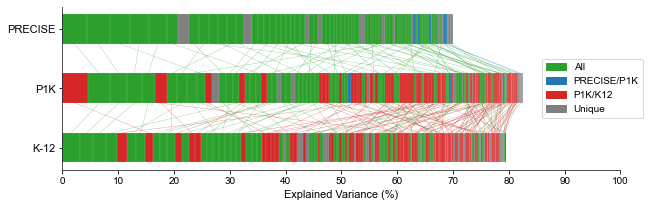

In [186]:
_, ax = plt.subplots(figsize=(10, 3))

prev_left = 0
bar_mids = {}
p1_pie = {memb: 0 for memb in color_dict.keys()}
for im, im_row in precise.imodulon_table.sort_values(by='exp_var', ascending=False).iterrows():
    im_member = im_count_dict.get(f'{im}_p1', 'Unique')
    p1_pie[im_member] += im_row['exp_var']*100
    ax.barh(3, im_row['exp_var']*100, left=prev_left, linewidth=0.1, height=0.75, color=color_dict[im_member])
    bar_mids[f'{im}_p1'] = prev_left + (im_row['exp_var']*100) / 2
    prev_left += im_row['exp_var']*100
p1_pie = {k: v/sum(p1_pie.values()) for k, v in p1_pie.items()}
    
prev_left = 0
p1k_pie = {memb: 0 for memb in color_dict.keys()}
for im, im_row in p1k.imodulon_table.sort_values(by='exp_var', ascending=False).iterrows():
    im_member = im_count_dict.get(f'{im}_p1k', 'Unique')
    col = color_dict[im_member]
    p1k_pie[im_member] += im_row['exp_var']*100
    ax.barh(1.5, im_row['exp_var']*100, left=prev_left, linewidth=0.1, height=0.75, color=col)
    bar_mids[f'{im}_p1k'] = prev_left + (im_row['exp_var']*100) / 2
    prev_left += im_row['exp_var']*100
    if f'{im}_p1k' in im_graph:
        preds = im_graph.predecessors(f'{im}_p1k')
        for pred in preds:
            ax.plot([bar_mids[pred], bar_mids[f'{im}_p1k']], [2.625, 1.875], color=col, linewidth=0.2)
p1k_pie = {k: v/sum(p1k_pie.values()) for k, v in p1k_pie.items()}
    
prev_left = 0
k12_pie = {memb: 0 for memb in color_dict.keys()}
for im, im_row in ica_data.imodulon_table.sort_values(by='exp_var', ascending=False).iterrows():
    im_member = im_count_dict.get(f'{im}_k12', 'Unique')
    col = color_dict[im_member]
    k12_pie[im_member] += im_row['exp_var']*100
    ax.barh(0, im_row['exp_var']*100, left=prev_left, linewidth=0.1, height=0.75, color=col)
    bar_mids[f'{im}_k12'] = prev_left + (im_row['exp_var']*100) / 2
    prev_left += im_row['exp_var']*100
    if f'{im}_k12' in im_graph:
        preds = im_graph.predecessors(f'{im}_k12')
        for pred in preds:
            if pred.split('_')[1] == 'p1k':
                ax.plot([bar_mids[pred], bar_mids[f'{im}_k12']], [1.125, 0.375], color=col, linewidth=0.2)
k12_pie = {k: v/sum(k12_pie.values()) for k, v in k12_pie.items()}
    
ax.set_xlim(0, 100)
ax.set_yticks([0, 1.5, 3])
ax.set_xticks(range(0, 110, 10))
ax.tick_params(axis='y', labelsize=11)
ax.set_yticklabels(['K-12', 'P1K', 'PRECISE'])
ax.set_xlabel('Explained Variance (%)', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend([Patch(color=col) for col in color_dict.values()], color_dict.keys(), loc='center left', bbox_to_anchor=(0.85, 0.5))

plt.savefig(os.path.join(FIG_PATH, 'im_lineage.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'im_lineage.png'), dpi=400, bbox_inches='tight')

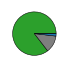

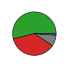

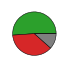

In [185]:
for pie_dict, lab in zip([p1_pie, p1k_pie, k12_pie], ['p1', 'p1k', 'k12']):
    _, ax = plt.subplots(figsize=(1, 1))
    sorted_labs, sorted_fracs = zip(*sorted(pie_dict.items(), key=lambda tup: tup[1], reverse=True))
    ax.pie(sorted_fracs, colors=[color_dict[lab] for lab in sorted_labs], wedgeprops={'edgecolor': 'k', 'linewidth': 0.5})
    plt.savefig(os.path.join(FIG_PATH, f'{lab}_pie.svg'), dpi=400, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_PATH, f'{lab}_pie.png'), dpi=400, bbox_inches='tight')